In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import joblib

In [2]:
SEQ_LEN = 60
EPOCHS = 100
BATCH_SIZE = 32
VAL_RATIO  = 0.2

In [3]:
os.makedirs("model", exist_ok=True)
os.makedirs("scaler", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [4]:
ticker = "LYFT"

In [5]:
features = ["Close"]
CLOSE_IDX = features.index("Close")

In [6]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, CLOSE_IDX])
    return np.array(X), np.array(y)

In [7]:
# Đọc dữ liệu
df = pd.read_csv(f"data/{ticker}_preprocess.csv")
df = df.sort_values("Date")

In [8]:
# Lấy dữ liệu theo features đã định nghĩa
data = df[features].values

In [9]:
# Chia tập train+val và test
total_len = len(data)
test_start_idx = int(total_len * 0.8)
train_val_data = data[:test_start_idx]
test_data = data[test_start_idx - SEQ_LEN:]

In [10]:
# Tách train và val từ train_val_raw
train_size = int(len(train_val_data) * (1 - VAL_RATIO))
train_data = train_val_data[:train_size]
val_data = train_val_data[train_size - SEQ_LEN:]

In [11]:
# Fit scaler trên train_raw
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [12]:
# Transform dữ liệu
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [13]:
# Tạo sequence
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_sequences(val_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

In [14]:
# Reshape dữ liệu cho LSTM
X_train = X_train.reshape((X_train.shape[0], SEQ_LEN, len(features)))
X_val = X_val.reshape((X_val.shape[0], SEQ_LEN, len(features)))
X_test = X_test.reshape((X_test.shape[0], SEQ_LEN, len(features)))

In [15]:
# Xây dựng mô hình
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    LSTM(64, return_sequences=False),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0542 - val_loss: 0.0012
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0037 - val_loss: 4.9726e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0030 - val_loss: 4.6688e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0027 - val_loss: 3.4089e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0024 - val_loss: 4.1005e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0022 - val_loss: 3.2714e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0020 - val_loss: 3.0085e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0021 - val_loss: 3.4074e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0024 - val_loss: 2.7791e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0018 - val_loss: 3.6165e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0018 - val_loss: 3.0942e-04
E

In [17]:
# Dự đoán và đảo chuẩn hóa
y_pred_scaled = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [18]:
# Chỉ chuẩn hóa lại cột Close
temp_array = np.zeros((len(y_pred_scaled), len(features)))
temp_array[:, CLOSE_IDX] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(temp_array)[:, CLOSE_IDX]

temp_array_true = np.zeros((len(y_test), len(features)))
temp_array_true[:, CLOSE_IDX] = y_test
y_true = scaler.inverse_transform(temp_array_true)[:, CLOSE_IDX]

In [19]:
# Đánh giá
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Đánh giá mô hình {ticker} trên tập test:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R^2:  {r2:.4f}")

Đánh giá mô hình LYFT trên tập test:
  MAE:  0.54
  RMSE: 0.81
  MAPE: 3.93%
  R^2:  0.8426


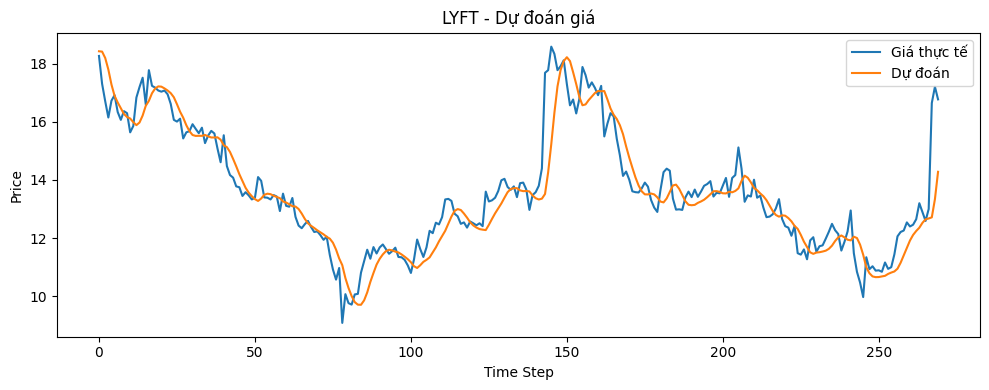

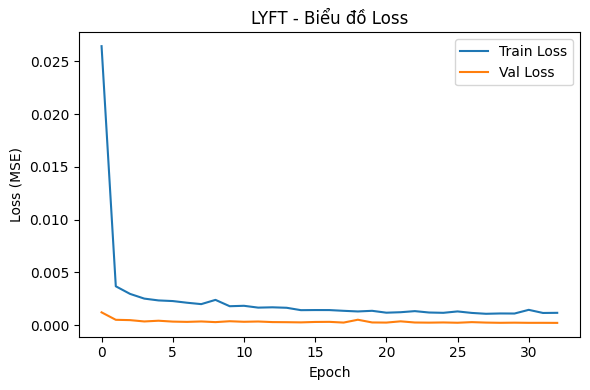

In [20]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Giá thực tế")
plt.plot(y_pred, label="Dự đoán")
plt.title(f"{ticker} - Dự đoán giá")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"{ticker} - Biểu đồ Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#model.save(f"model/{ticker}_model.h5")
#joblib.dump(scaler, f"scaler/{ticker}_scaler.pkl")